# AlexNet
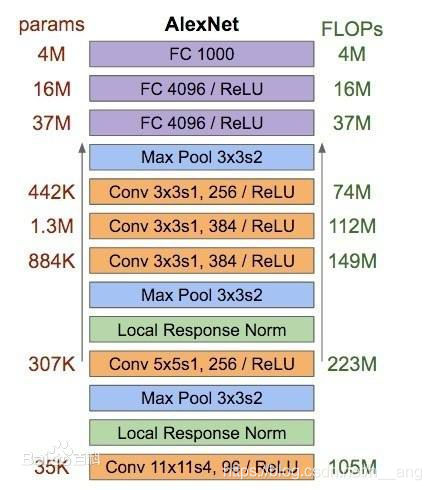

## Load Dependent Packages

In [1]:
import torch
import torchvision

## Device Configuration: CPU or GPU

In [2]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Select Hyper Parameters

In [3]:
num_epochs = 80
num_classes = 10
batch_size = 100
learning_rate = 0.0006

数据增强：https://blog.csdn.net/weixin_40793406/article/details/84867143

## Transform Configuration and Data Augmentation

In [4]:
transform_train = torchvision.transforms.Compose([torchvision.transforms.Pad(2),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.RandomCrop(32),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

## Load Downloaded Dataset (download=False)

In [5]:
train_dataset = torchvision.datasets.CIFAR10('../data/CIFAR10/', train=True, download=False, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10('../data/CIFAR10/', train=False, download=False, transform=transform_test)

## Set Data Loader (Input Pipeline)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
(6 - 2 + 2 * 0) / 2 + 1

3.0

## Define AlexNet Class

In [8]:
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes, init_weights=False):
        super(AlexNet, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=2),
                                          torch.nn.BatchNorm2d(64),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(64, 192, kernel_size=4, stride=1, padding=1),
                                          torch.nn.BatchNorm2d(192),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0))
        
        self.layer3 = torch.nn.Sequential(torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
                                          torch.nn.BatchNorm2d(384),
                                          torch.nn.ReLU(inplace=True))
        
        self.layer4 = torch.nn.Sequential(torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
                                          torch.nn.BatchNorm2d(256),
                                          torch.nn.ReLU(inplace=True))
        
        self.layer5 = torch.nn.Sequential(torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                          torch.nn.BatchNorm2d(256),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.avgpool = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(output_size=(3, 3)))
        
        self.fc1 = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(256 * 3 * 3, 1024),
                                       torch.nn.ReLU(inplace=True))
        
        self.fc2 = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(1024, 1024),
                                       torch.nn.ReLU(inplace=True))
        
        self.fc3 = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(1024, num_classes))
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

## Make Model with GPU

In [9]:
model = AlexNet(num_classes, True).to(device)

## Loss and Optimizer

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Update Learning Rate

In [11]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Train Model with GPU

In [12]:
import gc
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item())) 
        
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/80], Step [100/500], Loss 1.7641
Epoch [1/80], Step [200/500], Loss 1.3219
Epoch [1/80], Step [300/500], Loss 1.3826
Epoch [1/80], Step [400/500], Loss 1.2343
Epoch [1/80], Step [500/500], Loss 1.2426
Epoch [2/80], Step [100/500], Loss 1.1751
Epoch [2/80], Step [200/500], Loss 1.0635
Epoch [2/80], Step [300/500], Loss 1.2144
Epoch [2/80], Step [400/500], Loss 1.1216
Epoch [2/80], Step [500/500], Loss 1.2333
Epoch [3/80], Step [100/500], Loss 0.9114
Epoch [3/80], Step [200/500], Loss 1.1976
Epoch [3/80], Step [300/500], Loss 1.1030
Epoch [3/80], Step [400/500], Loss 0.9300
Epoch [3/80], Step [500/500], Loss 0.8047
Epoch [4/80], Step [100/500], Loss 1.0986
Epoch [4/80], Step [200/500], Loss 0.9220
Epoch [4/80], Step [300/500], Loss 1.0176
Epoch [4/80], Step [400/500], Loss 0.8595
Epoch [4/80], Step [500/500], Loss 0.8597
Epoch [5/80], Step [100/500], Loss 0.8618
Epoch [5/80], Step [200/500], Loss 0.7139
Epoch [5/80], Step [300/500], Loss 0.7958
Epoch [5/80], Step [400/500], Loss

## Test Model with .eval()

In [13]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print ('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 86.1 %


## Save the Model Checkpoint

In [14]:
torch.save(model.state_dict(), 'AlexNet(CIFAR10).ckpt')